In [ ]:
!pip install datasets pandas matplotlib


In [ ]:
from datasets import load_dataset
import re

# Load the AI-Dev dataset (train split)
data = load_dataset("hao-li/AIDEV", split="train")

# Check the number of records
print("Number of records:", len(data))

# Inspect the first record
record = data[0]
print("Available fields:", record.keys())


Number of records: 932791
Available fields: dict_keys(['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'repo_id', 'html_url', 'body', 'agent'])


In [ ]:
import pandas as pd
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDEV/all_pull_request.parquet")
print(pr_df.columns)
print(pr_df.head())


Index(['id', 'number', 'title', 'body', 'agent', 'user_id', 'user', 'state',
       'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url',
       'html_url'],
      dtype='object')
           id  number                                              title  \
0  3264016139    1688  `metta code` --> `metta clip` and additional p...   
1  3264021033      41  feat: Comprehensive ruff error resolution with...   
2  3264042289    1600  Add Evals frontend implementation plan and HTM...   
3  3264042318    1601  Add 4 new BfDs components for Evals interface ...   
4  3264067496       3  🚀 Complete Frontend-Backend API Integration wi...   

                                                body        agent    user_id  \
0  Remove unused `root_key` variable to fix ruff ...  Claude_Code      37011   
1  ## 🎯 Mission Accomplished: 100% Ruff Error Res...  Claude_Code  131842369   
2  \nCreate comprehensive implementation plan for...  Claude_Code    6766889   
3  \nPhase 1 component creation fo

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

Available fields: dict_keys(['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'repo_id', 'html_url', 'body', 'agent'])

--- First record ---
Title: `metta code` --> `metta clip` and additional polish
Body: Remove unused `root_key` variable to fix ruff linting error F841

🤖 Generated with [Claude Code](https://claude.ai/code)

Co-Authored-By: Claude <noreply@anthropic.com>

[Asana Task](https://app.asana.com/1/1209016784099267/project/1210348820405981/task/1210892261488990)

[Asana Task](https://app.asana.com/1/1209016784099267/project/1210348820405981/task/1210892111424511)
Agent: Claude_Code
State: closed
Merged at: 2025-07-25T19:17:23Z
Repo URL: https://api.github.com/repos/Metta-AI/metta

Sample keywords in accepted PRs: ['fix', 'error', 'Error', 'Error', 'Issue', 'error', 'Bug', 'Bug', 'Error', 'Fix', 'error', 'fix', 'Fix', 'fix', 'Issue', 'fix', 'fix', 'fix', 'error', 'patch']
Sample keywords in rejected PRs: ['error', 'Error

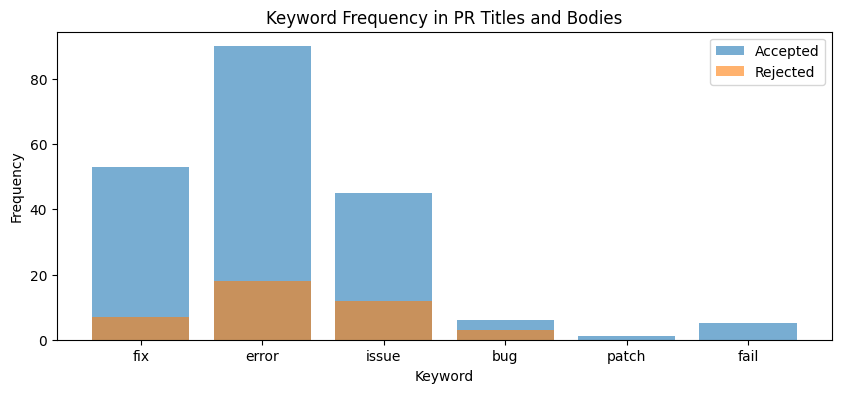

In [ ]:

# Step 3: Inspect first record
record = data[0]
print("Available fields:", record.keys())
print("\n--- First record ---")
print("Title:", record['title'])
print("Body:", record['body'])
print("Agent:", record['agent'])
print("State:", record['state'])
print("Merged at:", record['merged_at'])
print("Repo URL:", record['repo_url'])

# Step 4: Define keywords to look for in PR context
keywords_pattern = r'\b(fix|bug|error|issue|patch|fail)\b'

# Step 5: Separate accepted vs rejected PRs based on state/merged_at
accepted_keywords = []
rejected_keywords = []

# Loop through first 100 records as a start
for rec in data.select(range(100)):
    text = (rec['title'] or "") + " " + (rec['body'] or "")
    kw = re.findall(keywords_pattern, text, flags=re.IGNORECASE)
    if rec['state'] == 'closed' and rec['merged_at'] is not None:
        accepted_keywords.extend(kw)
    else:
        rejected_keywords.extend(kw)

# Step 6: Show some results
print("\nSample keywords in accepted PRs:", accepted_keywords[:20])
print("Sample keywords in rejected PRs:", rejected_keywords[:20])

# Step 7: Simple visualization
plt.figure(figsize=(10,4))

# Accepted PR keywords frequency
accepted_count = Counter([k.lower() for k in accepted_keywords])
plt.bar(accepted_count.keys(), accepted_count.values(), alpha=0.6, label='Accepted')

# Rejected PR keywords frequency
rejected_count = Counter([k.lower() for k in rejected_keywords])
plt.bar(rejected_count.keys(), rejected_count.values(), alpha=0.6, label='Rejected')

plt.title("Keyword Frequency in PR Titles and Bodies")
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.legend()
plt.show()

===== Average Metrics (RQ2) =====
      state  context_length  bug_density  test_rate
0  accepted      290.615584     0.009101   0.009206
1  rejected      263.978261     0.008950   0.011416


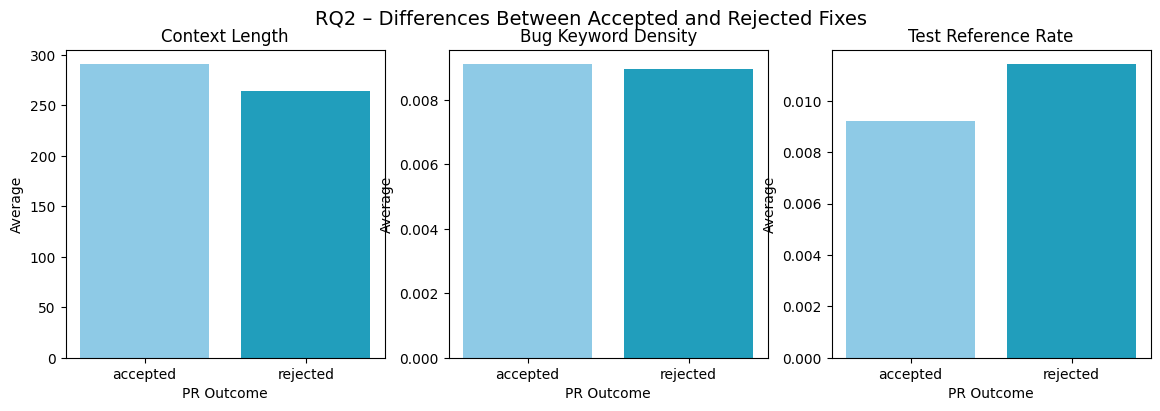


===== Agent Comparison (Bug/Test Rates) =====
         agent     state  bug_density  test_rate
0  Claude_Code  accepted     0.009101   0.009206
1  Claude_Code  rejected     0.008950   0.011416


In [ ]:
# ===============================================
# 📊 AI Agentic Repair Analysis (RQ2 Quantitative)
# ===============================================

!pip install datasets matplotlib --quiet

from datasets import load_dataset
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np
import pandas as pd

# ----------------------------
# 1️⃣ Load dataset
# ----------------------------
data = load_dataset("hao-li/AIDEV", split="train")

# ----------------------------
# 2️⃣ Define patterns & setup
# ----------------------------
bug_pattern = r'\b(fix|bug|error|issue|patch|fail|lint)\b'
test_pattern = r'\b(test|unit|assert|verify|coverage)\b'

records = []

# ----------------------------
# 3️⃣ Process each PR record
# ----------------------------
for rec in data.select(range(1000)):  # sample for speed
    text = f"{rec.get('title','')} {rec.get('body','')}"
    word_count = len(text.split())

    bug_keywords = re.findall(bug_pattern, text, flags=re.IGNORECASE)
    test_keywords = re.findall(test_pattern, text, flags=re.IGNORECASE)

    if word_count == 0:
        continue  # skip empty

    # compute metrics
    bug_density = len(bug_keywords) / word_count
    test_rate = len(test_keywords) / word_count
    context_length = word_count

    records.append({
        'state': 'accepted' if rec['state']=='closed' and rec['merged_at'] else 'rejected',
        'bug_density': bug_density,
        'test_rate': test_rate,
        'context_length': context_length,
        'agent': rec.get('agent', 'Unknown')
    })

df = pd.DataFrame(records)

# ----------------------------
# 4️⃣ Compute group averages
# ----------------------------
summary = df.groupby('state')[['context_length', 'bug_density', 'test_rate']].mean().reset_index()
print("===== Average Metrics (RQ2) =====")
print(summary)

# ----------------------------
# 5️⃣ Visualize differences
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['context_length', 'bug_density', 'test_rate']
titles = ['Context Length', 'Bug Keyword Density', 'Test Reference Rate']

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(summary['state'], summary[metric], color=['#8ecae6', '#219ebc'])
    ax.set_title(title)
    ax.set_ylabel('Average')
    ax.set_xlabel('PR Outcome')

plt.suptitle("RQ2 – Differences Between Accepted and Rejected Fixes", fontsize=14)
plt.show()

# ----------------------------
# 6️⃣ Optional: Agent Comparison
# ----------------------------
agent_summary = df.groupby(['agent', 'state'])[['bug_density', 'test_rate']].mean().reset_index()
print("\n===== Agent Comparison (Bug/Test Rates) =====")
print(agent_summary.head(10))


📊 متوسط العناصر البرمجية المستخرجة:
         functions  variables     files
state                                 
closed   0.005988   0.640719  0.550898
open     0.030303   2.303030  0.454545


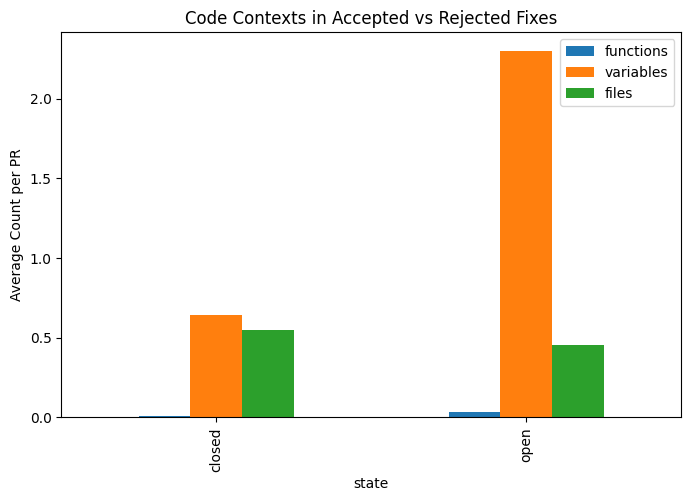

In [ ]:
# Step 1: تحميل المكتبات
import re
import pandas as pd
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt

# Step 2: تحميل البيانات من AI-Dev
data = load_dataset("hao-li/AIDEV", split="train")

# Step 3: إنشاء دالة لاستخراج السياق البرمجي
def extract_code_context(text):
    """
    استخراج الدوال، المتغيرات، ومسارات الملفات من نصوص الـ PR
    """
    functions = re.findall(r'\bdef\s+([a-zA-Z_][a-zA-Z0-9_]*)', text)
    variables = re.findall(r'\b([a-zA-Z_][a-zA-Z0-9_]*)\s*=', text)
    files = re.findall(r'[\w/\\-]+\.py', text)
    return functions, variables, files

# Step 4: تحليل أول 200 سجل فقط
contexts = []
for rec in data.select(range(200)):
    text = (rec['title'] or "") + "\n" + (rec['body'] or "")
    funcs, vars_, files = extract_code_context(text)
    contexts.append({
        "state": rec["state"],
        "agent": rec["agent"],
        "functions": len(funcs),
        "variables": len(vars_),
        "files": len(files)
    })

# Step 5: تحويل النتائج إلى DataFrame
df = pd.DataFrame(contexts)

# Step 6: حساب المتوسطات للمقارنة
summary = df.groupby("state")[["functions", "variables", "files"]].mean()
print("📊 متوسط العناصر البرمجية المستخرجة:\n", summary)

# Step 7: رسم النتائج
summary.plot(kind="bar", figsize=(8,5), title="Code Contexts in Accepted vs Rejected Fixes")
plt.ylabel("Average Count per PR")
plt.show()


In [ ]:
# Step 1: تحميل المكتبات
from datasets import load_dataset
import re

# Step 2: تحميل البيانات
data = load_dataset("hao-li/AIDEV", split="train")

# Step 3: اختيار مثالين
accepted_example = None
rejected_example = None

for rec in data:
    if rec["state"] == "closed" and rec["merged_at"] is not None and accepted_example is None:
        accepted_example = rec
    elif rec["state"] == "open" and rejected_example is None:
        rejected_example = rec
    if accepted_example and rejected_example:
        break

# Step 4: طباعة الأمثلة للمقارنة
print("🟢 Accepted Fix Example:")
print("Title:", accepted_example["title"])
print("Body:", accepted_example["body"])
print("Agent:", accepted_example["agent"])
print("Repo:", accepted_example["repo_url"])
print("-"*80)

print("🔴 Rejected Fix Example:")
print("Title:", rejected_example["title"])
print("Body:", rejected_example["body"])
print("Agent:", rejected_example["agent"])
print("Repo:", rejected_example["repo_url"])


🟢 Accepted Fix Example:
Title: `metta code` --> `metta clip` and additional polish
Body: Remove unused `root_key` variable to fix ruff linting error F841

🤖 Generated with [Claude Code](https://claude.ai/code)

Co-Authored-By: Claude <noreply@anthropic.com>

[Asana Task](https://app.asana.com/1/1209016784099267/project/1210348820405981/task/1210892261488990)

[Asana Task](https://app.asana.com/1/1209016784099267/project/1210348820405981/task/1210892111424511)
Agent: Claude_Code
Repo: https://api.github.com/repos/Metta-AI/metta
--------------------------------------------------------------------------------
🔴 Rejected Fix Example:
Title: feat: Comprehensive ruff error resolution with version alignment and governance
Body: ## 🎯 Mission Accomplished: 100% Ruff Error Resolution

**Achievement**: Resolved all 80 ruff errors (100% success rate) through systematic version alignment and expert-validated governance framework.

### 📊 Results Summary
- **Baseline**: 80 ruff errors (100%)
- **Fina